In [9]:
from typing import Callable, Optional, Tuple, Any, List, Dict
import os
from contextlib import contextmanager

import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
import torchvision.transforms as T
from torchvision.transforms import v2
from torchvision.datasets import DatasetFolder, ImageFolder, VisionDataset
from torchvision import models
from torch.utils.data import Subset, DataLoader
import numpy as np
import pandas as pd
from PIL import Image

from data import SportDataset, display_random_samples
from utils import temp_seed
from train import val_step

Load train and test datasets:

In [10]:
transforms = v2.Compose([
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
dataset = SportDataset('./hw-ucu-12023-4-100-sports-image-classification', transform=transforms, train=True)
transforms = v2.Compose([
    T.ToTensor(),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
test_dataset = SportDataset('./hw-ucu-12023-4-100-sports-image-classification', transform=transforms, train=False)
assert len(dataset) == 13695
assert len(test_dataset) == 797

Split dataset into train and val

Display samples from train, val and test parts:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


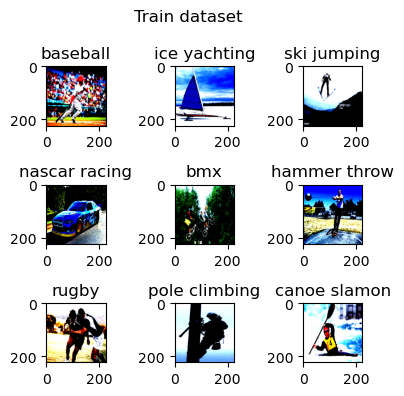

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


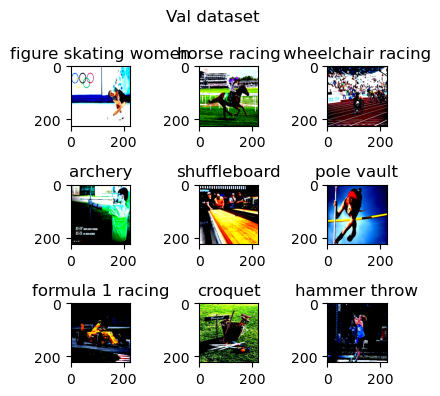

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


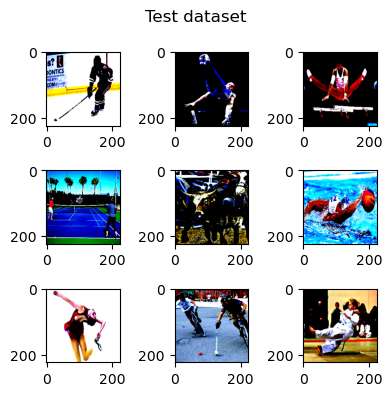

In [11]:
with temp_seed(42):
    train_dataset, val_dataset = torch.utils.data.random_split(dataset, [0.9, 0.1])

    fig = plt.figure(figsize=(4, 4))
    fig.suptitle('Train dataset')
    display_random_samples(train_dataset, 9, fig=fig, idx_to_class=dataset.idx_to_class)
    plt.tight_layout()
    plt.show()

    fig = plt.figure(figsize=(4, 4))
    fig.suptitle('Val dataset')
    display_random_samples(val_dataset, 9, fig=fig, idx_to_class=dataset.idx_to_class)
    plt.tight_layout()
    plt.show()

    fig = plt.figure(figsize=(4, 4))
    fig.suptitle('Test dataset')
    display_random_samples(test_dataset, 9, fig=fig)
    plt.tight_layout()
    plt.show()


In [4]:
model = models.alexnet(weights=models.AlexNet_Weights.IMAGENET1K_V1)
in_features = model.classifier[6].weight.shape[1]
model.classifier[6] = nn.Linear(in_features, SportDataset.NUM_CLASSES)

In [12]:
model = models.vit_h_14(weights=models.ViT_H_14_Weights.IMAGENET1K_SWAG_LINEAR_V1)
in_features = model.heads.head.in_features
model.heads.head = nn.Linear(in_features, SportDataset.NUM_CLASSES)

In [13]:
model.cuda();

OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacty of 2.95 GiB of which 1.69 MiB is free. Including non-PyTorch memory, this process has 2.94 GiB memory in use. Of the allocated memory 2.81 GiB is allocated by PyTorch, and 70.44 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [8]:
NUM_EPOCHS = 100
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, drop_last=True, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False, drop_last=False, pin_memory=True)
optimizer = torch.optim.AdamW(model.parameters())

val_loss, val_acc = val_step(model, val_loader)
print(f"Preliminary val:\t{val_loss:.2f} loss \t {val_acc:.3f} acc\n")

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2, threshold=0.01)

for epoch in range(NUM_EPOCHS):
    lr = optimizer.param_groups[0]['lr']
    print(f"lr = {lr}")
    if lr < 1e-6:
        break

    model.train()
    train_loss = torch.tensor(0.0, dtype=torch.float32, device='cuda')
    train_count = 0
    train_correct = torch.tensor(0, device='cuda')
    for it, (imgs, labels) in enumerate(train_loader):
        imgs, labels = imgs.cuda(), labels.cuda()
        logits = model(imgs)
        loss = F.cross_entropy(logits, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_count += len(imgs)
        with torch.no_grad():
            train_loss += loss * len(imgs)
            train_correct += torch.sum(torch.argmax(logits, axis=1) == labels)

    print(f"Train epoch {epoch}:\t{train_loss.item() / train_count:.2f} loss \t {train_correct.item() / train_count:.3f} acc")

    val_loss, val_acc = val_step(model, val_loader)
    print(f"Val epoch {epoch}:\t{val_loss:.2f} loss \t {val_acc:.3f} acc\n")

    scheduler.step(val_loss)


OutOfMemoryError: CUDA out of memory. Tried to allocate 162.00 MiB. GPU 0 has a total capacty of 2.95 GiB of which 21.69 MiB is free. Including non-PyTorch memory, this process has 2.92 GiB memory in use. Of the allocated memory 2.80 GiB is allocated by PyTorch, and 60.08 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF